# Setup

In [203]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from matplotlib.gridspec import GridSpec
from math import ceil



In [204]:
import os
print(os.getcwd())
file_path =  'C:/Users/User/OneDrive/Documents/Udem/SciNeurotech/datasets/5d_rat/BCI00_5D.mat' #'5D_step4.mat' 
print(os.path.abspath(file_path))
print("File exists:", os.path.isfile(file_path))

c:\Users\User\Documents\SciNeuroTech\additive-neurostimulation\src\utils
C:\Users\User\OneDrive\Documents\Udem\SciNeurotech\datasets\5d_rat\BCI00_5D.mat
File exists: True


In [205]:
data = scipy.io.loadmat(file_path)
resp = data['emg_response'] 
param = data['stim_combinations']
ch2xy =  param[:, [0,1,2,5,6]]
resp.shape # nb repetitions x emg channels x nb combinations x emg metric 

(8, 5, 2048, 4)

In [206]:
peak_resp = resp[:, :, :, 0]
auc_resp = resp[:, :, :, 1]
peak_norm_resp = resp[:, :, :, 2]
auc_norm_resp = resp[:, :, :, 3] 

# Description

response shape is (nb repetitions, emg channel, combinations, emg metric)

param contains all combinations of paremeters, being param (2048, 7): (PW (us), freq (Hz), stim_train_duration (ms), count, channel, x_ch, y_ch)



In [207]:
ch2xy.shape # nb channels x nb spatial dimensions

(2048, 5)

# Mean, std and filtering preprocessing

In [208]:
def create_mean_map(resp):

    resp_mu = np.mean(resp,axis=0)
    mean_map = np.zeros((resp.shape[1],4,4,4,8,4))

    for e in range(resp.shape[1]):

        val_pw = np.unique(param[:,0])
        val_freq = np.unique(param[:,1])
        val_duration = np.unique(param[:,2])
        val_pos = np.unique(param[:,4])

        for i in range(len(param)):

            idx_pw = np.where(np.isclose(val_pw, param[i, 0]))[0][0]
            idx_freq = np.where(np.isclose(val_freq, param[i, 1]))[0][0]
            idx_duration = np.where(np.isclose(val_duration, param[i, 2]))[0][0]

            x_ch = int(ch2xy[i,3]) -1 # int(param[i,4]) % 8 #some operation here
            y_ch = int(ch2xy[i,4]) -1 # int(param[i,4]) % 4

            mean_map[e, idx_pw, idx_freq, idx_duration, x_ch, y_ch] = resp_mu[e,i]

    return mean_map

def create_std_map(resp):

    resp_sigma = np.std(resp,axis=0)
    std_map = np.zeros((resp.shape[1],4,4,4,8,4))

    for e in range(resp.shape[1]):

        val_pw = np.unique(param[:,0])
        val_freq = np.unique(param[:,1])
        val_duration = np.unique(param[:,2])
        val_pos = np.unique(param[:,4])

        for i in range(len(param)):

            idx_pw = np.where(np.isclose(val_pw, param[i, 0]))[0][0]
            idx_freq = np.where(np.isclose(val_freq, param[i, 1]))[0][0]
            idx_duration = np.where(np.isclose(val_duration, param[i, 2]))[0][0]

            x_ch = int(ch2xy[i,3]) -1 # int(param[i,4]) % 8 #some operation here
            y_ch = int(ch2xy[i,4]) -1 # int(param[i,4]) % 4

            std_map[e, idx_pw, idx_freq, idx_duration, x_ch, y_ch] = resp_sigma[e,i]

    return std_map

def filter_responses(resp, param, ch2xy):
    """
    Return a 0/1 array `valid_resp` (same shape as resp) where
    1 = the response does NOT deviate by more than 1*std from the mean
    0 = deviates by more than 1*std
    """

    mean_map = create_mean_map(resp)
    std_map = create_std_map(resp)

    n_reps, n_emgs, n_cond = resp.shape
    valid_resp = np.zeros_like(resp, dtype=np.int64)

    val_pw = np.unique(param[:,0])
    val_freq = np.unique(param[:,1])
    val_duration = np.unique(param[:,2])

    EPS = 1e-12

    for i in range(n_cond):
        # find indices in the map corresponding to this condition
        idx_pw = np.where(np.isclose(val_pw, param[i, 0]))[0][0]
        idx_freq = np.where(np.isclose(val_freq, param[i, 1]))[0][0]
        idx_duration = np.where(np.isclose(val_duration, param[i, 2]))[0][0]
        x_ch = int(ch2xy[i, 3]) - 1
        y_ch = int(ch2xy[i, 4]) - 1

        for j in range(n_emgs):

            # extract mean/std vectors for this condition
            mean_vec = mean_map[j, idx_pw, idx_freq, idx_duration, x_ch, y_ch]   # shape (1,)
            std_vec = std_map[j, idx_pw, idx_freq, idx_duration, x_ch, y_ch] 

            #print(f'mean_vec: {mean_vec} and std_vec: {std_vec}')
            deviation = np.abs(resp[:, j, i] - mean_vec)
            #print(f'deviation: {deviation}')
            valid_mask = deviation <= 2*std_vec
            #print(valid_mask)
            valid_resp[:, j, i] = valid_mask.astype(np.int64)

    
    # print summary
    total = resp.size
    valid_count = int(valid_resp.sum())
    invalid_count = total - valid_count
    print(f"Total responses: {total}")
    print(f"Valid responses: {valid_count} ({valid_count/total*100:.2f}%)")
    print(f"Invalid responses: {invalid_count} ({invalid_count/total*100:.2f}%)")

    return valid_resp


# Visualizing responses for specific EMG channel and temporal values

In [251]:

def exp_plot_pw_dur(emg_ch, mean_map, f = 3):
    
    print('EMG channel selected: '+ str(emg_ch))

    fig, ax = plt.subplots(3,4)
    vmin = np.min(mean_map[emg_ch, :, f, :, :, :])
    vmax = np.max(mean_map[emg_ch, :, f, :, :, :])
    
    for i in range(3):
        
        for j in range(4):
        
            ax[i,j].imshow(mean_map[emg_ch, j, f, i, :, :], vmin=vmin, vmax=vmax)
            #ax[i,j].set_title('PW = '+str(int(np.round(val_p0[i]))))
            
    plt.tight_layout()

def exp_plot(emg_ch, mean_map, pw = 3):
    
    
    val_p0 = np.unique(param[:,0])
    val_p1 = np.unique(param[:,1])
    val_p2 = np.unique(param[:,2])

    print('EMG channel selected: '+ str(emg_ch) + f'with Pulse width: {val_p0[pw]}')

    fig, ax = plt.subplots(4,4, figsize=(10,16))
    vmin = np.min(mean_map[emg_ch, :, :, :, :, :])
    vmax = np.max(mean_map[emg_ch, :, :, :, :, :])
    best_mean_val = np.argmax(mean_map[emg_ch])
    best_mean_combination = ch2xy[best_mean_val]
    print(f'range of values: [{vmin}, {vmax}]')
    print(f'best stim combination: {best_mean_val}')
    print(f'combinations: (pw, freq, dur, x+1, y+1):  {best_mean_combination}')
    for j in range(4):
               
        for i in range(4):
            ax[j, i].imshow(mean_map[emg_ch, pw, i, j, :, :], vmin=vmin, vmax=vmax)
            ax[j, i].set_title('freq = '+str(int(np.round(val_p1[i]))) + ' dur = '+str(int(np.round(val_p2[j]))))


EMG channel selected: 3with Pulse width: 300.00001192092896
range of values: [5.583030117885549e-07, 0.00032383289408011]
best stim combination: 1110
combinations: (pw, freq, dur, x+1, y+1):  [300.00001192 100.         100.           4.           4.        ]


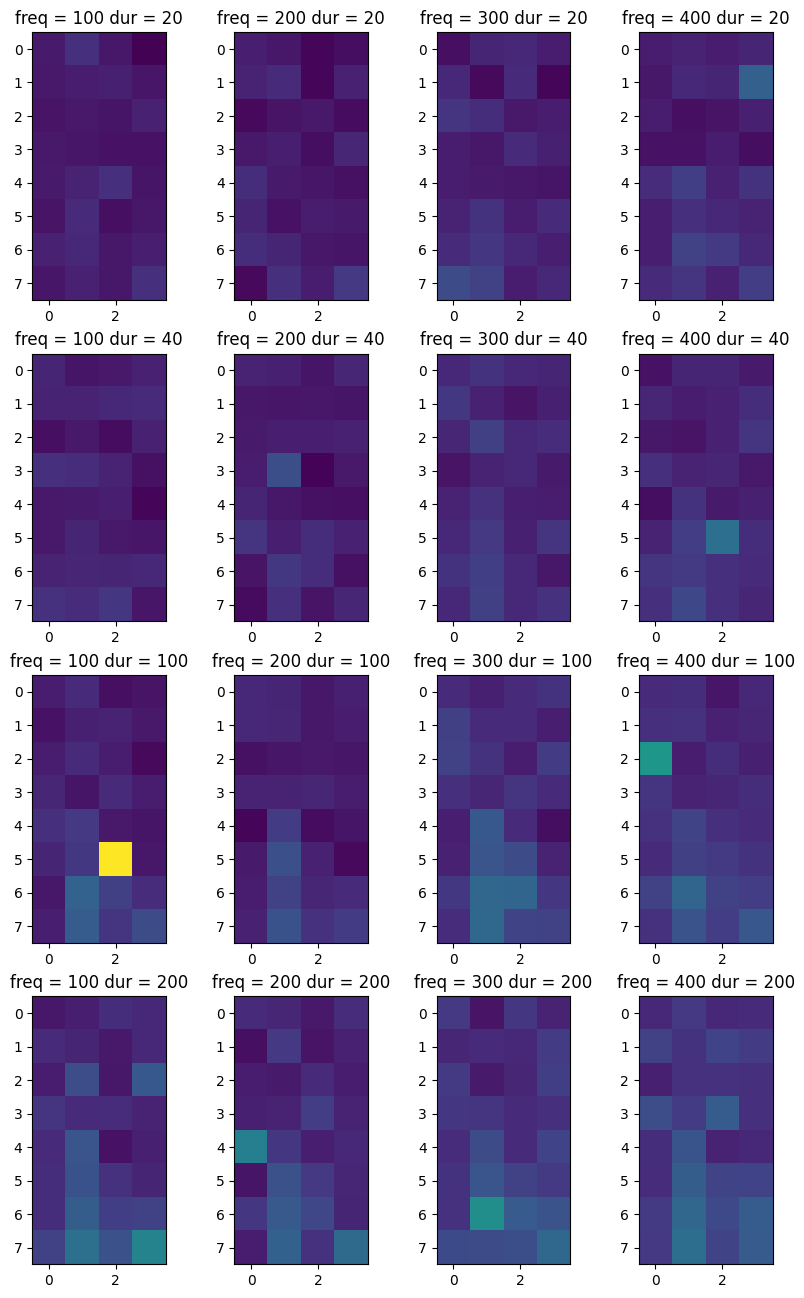

In [257]:
sampled_indices = np.random.choice(peak_norm_resp.shape[0], size=6, replace=False)

# Extract the sampled dimensions
sampled_resp = peak_norm_resp[sampled_indices, :, :]

#sampled_mean_map = create_mean_map(sampled_resp)

peak_map = create_mean_map(peak_norm_resp)
emg_ch = 3
exp_plot(emg_ch, peak_map, pw=2)

# Analysis of variance of EMG channels

In [211]:
def visualize_std_map(std_map,
                      emg_labels=None,
                      show=True):
    """
    Visualize averaged std maps for each EMG.

    Args:
        std_map : np.ndarray
            Array shaped (n_emg, P, F, D, X, Y) -- e.g. (n_emg,4,4,4,8,4)
        emg_labels : sequence or None
            Optional list/array of length n_emg for subplot titles.
        show : bool
            If True, calls plt.show().

    Returns:
        fig, axes, avg_maps : matplotlib.Figure, array of Axes, np.ndarray
            The created figure, flattened axes array, and averaged maps (n_emg, X, Y).
    """


    n_emg = std_map.shape[0]
    avg = np.mean(std_map, axis=(1, 2, 3))   # shape -> (n_emg, X, Y)
    # Ensure we treat NaNs properly
    global_min = np.nanmin(avg)
    global_max = np.nanmax(avg)

    # Avoid vmin == vmax (flat image) — expand slightly if needed
    if np.isclose(global_min, global_max):
        pad = 1e-6 * (1.0 + abs(global_min))
        global_min -= pad
        global_max += pad

    # Prepare subplots

    fig, axes = plt.subplots(1, n_emg, figsize=(4*n_emg, 5), squeeze=False)
    axes_flat = axes.flatten()

    # Plot each EMG heatmap. transpose so rows=Y (vertical), cols=X (horizontal)
    im = None
    for e in range(n_emg):
        ax = axes_flat[e]
        # avg[e] shape (X, Y) -> transpose to (Y, X) for imshow
        arr = avg[e].T
        im = ax.imshow(arr, origin='lower', vmin=global_min, vmax=global_max, aspect='auto', cmap='viridis')
        title = f"EMG {e}" if emg_labels is None else str(emg_labels[e])
        ax.set_title(title, fontsize=10)
        # set ticks to integer channel indices (1-based for readability)
        x_ticks = np.arange(arr.shape[1])
        y_ticks = np.arange(arr.shape[0])
        ax.set_xticks(x_ticks)
        ax.set_yticks(y_ticks)
        ax.set_xlabel("x_ch (1..{})".format(arr.shape[1]))
        ax.set_ylabel("y_ch (1..{})".format(arr.shape[0]))
        ax.set_xticklabels((x_ticks + 1).astype(int), fontsize=8)
        ax.set_yticklabels((y_ticks + 1).astype(int), fontsize=8)

    # Hide unused axes
    for j in range(n_emg, len(axes_flat)):
        axes_flat[j].axis('off')

    # Shared colorbar for all subplots
    if im is not None:
        cbar = fig.colorbar(im, ax=axes_flat, pad=0.05)
        cbar.set_label("Std (averaged over pw/freq/duration)")

    fig.suptitle("Std maps averaged across pw/freq/duration", fontsize=12)

    if show:
        plt.show()

    return fig, axes_flat[:n_emg], avg


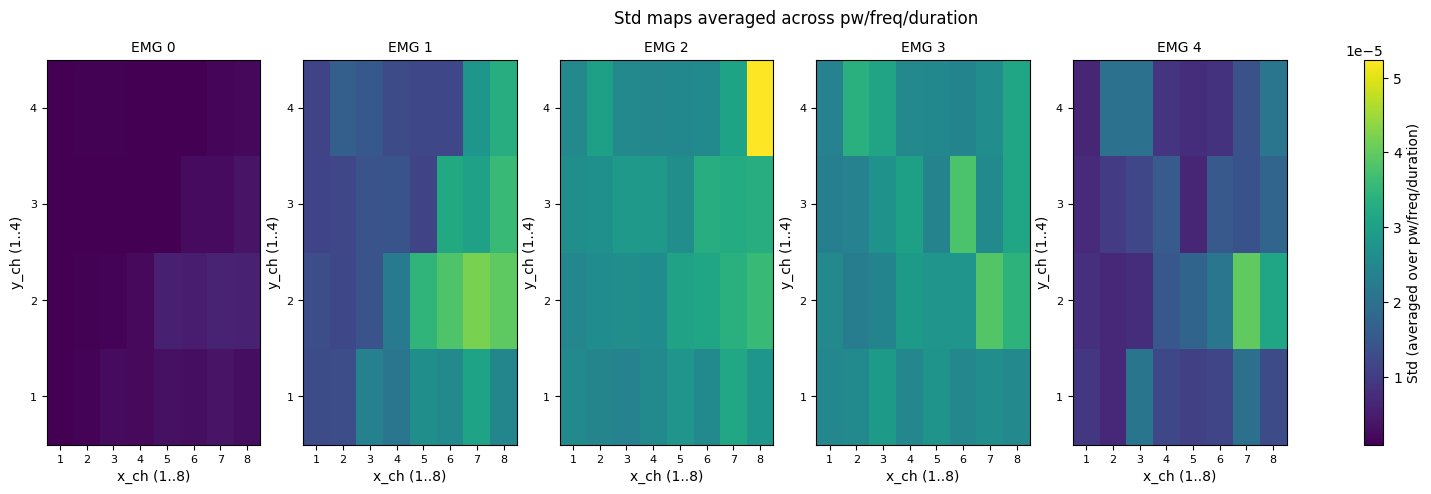

In [212]:
std_map = create_std_map(peak_resp)   # your existing function that returns the array
mean_map = create_mean_map(peak_resp)
fig, axes, avg_maps = visualize_std_map(std_map)

In [175]:
def plot_emg_response_distributions(mean_map,
                                        std_map,
                                        bins=100,
                                        show=True):
    """
    Plot distributions of mean and std responses across all EMGs.
    Rows = EMGs, Columns = [Mean, Std]

    Args:
        mean_map : np.ndarray
            Shape (n_emg, x, y, z, a, b)
        std_map : np.ndarray
            Shape (n_emg, x, y, z, a, b)
        bins : int
            Number of histogram bins
        show : bool
            If True, calls plt.show()

    Returns:
        fig, axes
    """

    if mean_map.shape != std_map.shape:
        raise ValueError("mean_map and std_map must have identical shapes")

    n_emg = mean_map.shape[0]

    # ---- Flatten all values (for global x-limits) ----
    mean_all = mean_map.reshape(n_emg, -1)
    std_all = std_map.reshape(n_emg, -1)


    mean_min =0
    mean_max = 0.0003

    # ---- Create figure ----
    fig, axes = plt.subplots(
        n_emg, 1,
        figsize=(10, 2.5 * n_emg),
        sharex='col',
        squeeze=False
    )

    for e in range(n_emg):
        # ---- Mean ----
        axes[e, 0].hist(
            mean_all[e],
            bins=bins,
            density=True,
            alpha=0.75
        )
        axes[e, 0].set_xlim(mean_min, mean_max)
        axes[e, 0].set_ylabel(f"EMG {e}")

        # ---- Std ----
        axes[e, 0].hist(
            std_all[e],
            bins=bins,
            density=True,
            alpha=0.75,
            color='red'
        )
        

    # Column titles
    axes[0, 0].set_title("Mean and STDs distributions")

    # Bottom x-labels only
    axes[-1, 0].set_xlabel("Response")

    fig.suptitle("Neural response distributions across EMGs", fontsize=12)
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    if show:
        plt.show()

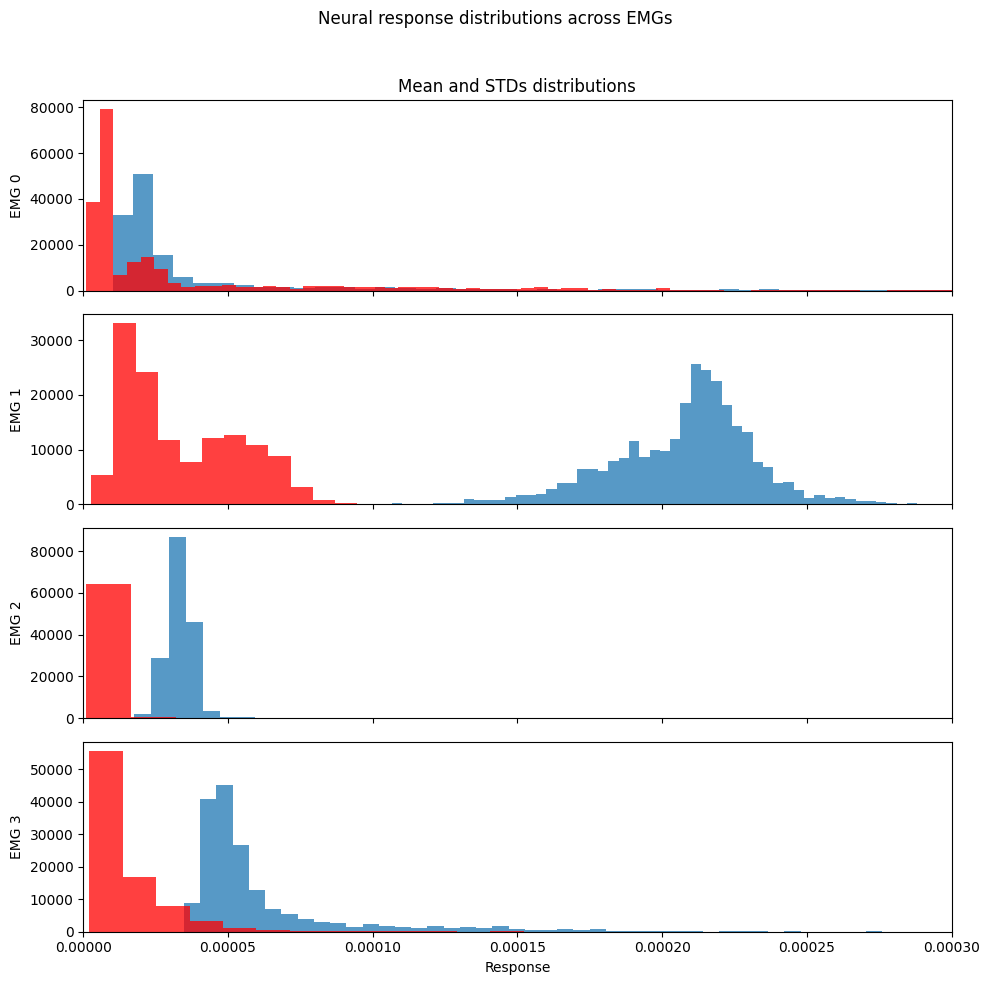

In [176]:
plot_emg_response_distributions(mean_map, std_map)

In [282]:
def analyzing_best_k(emg_ch, resp_map, top_k):
    
    mean_map = create_mean_map(resp_map)
    std_map = create_std_map(resp_map)
    
    val_p0 = np.unique(param[:,0])
    val_p1 = np.unique(param[:,1])
    val_p2 = np.unique(param[:,2])

    print('EMG channel selected: '+ str(emg_ch))

    vmin = np.min(mean_map[emg_ch, :, :, :, :, :])
    vmax = np.max(mean_map[emg_ch, :, :, :, :, :])
    sorted_indices = np.argsort(mean_map[emg_ch].flatten())
    top_k_indices = sorted_indices[::-1][:-top_k]
    top_k_mean_vals = mean_map[emg_ch].flatten()[top_k_indices]

    print(f'range of values: [{vmin}, {vmax}]\n\n')

    for i in range(top_k):

        print(f'Rank {i} | combination {top_k_indices[i]} = {top_k_mean_vals[i]}')
        stimulation_params = ch2xy[top_k_indices[i]]
        print(f'stimulation parameters: {stimulation_params}')


        idx_pw = np.where(np.isclose(val_p0, param[top_k_indices[i], 0]))[0][0]
        idx_freq = np.where(np.isclose(val_p1, param[top_k_indices[i], 1]))[0][0]
        idx_duration = np.where(np.isclose(val_p2, param[top_k_indices[i], 2]))[0][0]

        x_ch = int(ch2xy[i,3]) -1 # int(param[i,4]) % 8 #some operation here
        y_ch = int(ch2xy[i,4]) -1 # int(param[i,4]) % 4

        print(f'standard deviation: {std_map[emg_ch, idx_pw, idx_freq, idx_duration, x_ch, y_ch]}')
        print(f'responses: {resp_map[:, emg_ch, top_k_indices[i]]}\n\n')
        

    

In [284]:
analyzing_best_k(0, peak_resp, 5)

EMG channel selected: 0
range of values: [5.313524678581248e-06, 3.871185854971886e-05]


Rank 0 | combination 1909 = 3.871185854971886e-05
stimulation parameters: [400.00000596 300.         200.           7.           4.        ]
standard deviation: 1.1630923083662992e-06
responses: [9.36410211e-06 1.55909844e-05 1.23390376e-05 1.00407448e-05
 1.25092237e-05 1.40073898e-05 1.42201427e-05 1.42416700e-05]


Rank 1 | combination 2037 = 3.7329585742586576e-05
stimulation parameters: [400.00000596 400.         200.           7.           4.        ]
standard deviation: 4.558569861722328e-06
responses: [1.13072908e-05 9.91405928e-06 1.07166129e-05 1.23681160e-05
 1.14200653e-05 1.22885473e-05 1.52622552e-05 1.15065242e-05]


Rank 2 | combination 2005 = 3.6616084647763425e-05
stimulation parameters: [400.00000596 400.         100.           7.           4.        ]
standard deviation: 8.862071666272946e-07
responses: [1.74451546e-05 1.11106742e-05 9.36040885e-06 1.13769019e-05
 1.18951971e-0